# Chainerハンズオン: Pythonによるディープラーニング入門

## 目的

ニューラルネットワークを用いた画像認識タスクを通じてChainerの使い方と特徴を理解する

## このハンズオンで学べるChainerの特長

1. デバッグのしやすさ
2. CPUとGPUで共通のArray操作

## 目次

### Section 1. パーセプトロンによるMNIST画像分類

単純なニューラルネットワークで数値画像の分類タスクに挑戦する

* 多層パーセプトロンの構築と訓練
* 結果の評価と可視化 
* モデルの改良とデバッグ

### Section 2. Chainerの基礎

Chainerのデータ構造と実装の特徴をまとめる

* NumPyとCuPy
* VariableとFunction
* LinkとChain
* Define-by-Run



In [1]:
## Install Chainer and CuPy!

!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install cupy-cuda80 chainer

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcusparse8.0 is already the newest version (8.0.61-1).
libnvrtc8.0 is already the newest version (8.0.61-1).
libnvtoolsext1 is already the newest version (8.0.61-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


### 準備: Chainerのインポート

最初にChainerと関連モジュールをインポートする。CuPyについては後ほど説明する。

In [2]:
## Import Chainer 
from chainer import Chain, Variable, optimizers, serializers, datasets, training
from chainer.training import extensions
import chainer.functions as F
import chainer.links as L
import chainer

## Import NumPy and CuPy
import numpy as np
import cupy as cp

## Utilities
import time
import math

print('Chainer version: ', chainer.__version__)

Chainer version:  4.3.1


## Section 1. パーセプトロンによるMNIST画像分類

MNISTは機械学習でよく用いられる分類問題のベンチマークデータセットである。手書き数値文字画像を7万サンプル含み、それぞれに0から9までの正解ラベルが与えられている。タスクは、与えられた画像の数値を予測することであり、10クラス分類問題に相当する。

<img src="https://raw.githubusercontent.com/hido/chainer-handson/master/image/mnist.png">

各サンプルは縦横28x28のグレースケール画像（784次元ベクトル）である。

#### 定義: 多層パーセプトロン(2層)

最も単純なニューラルネットワークモデルとして、2層の多層パーセプトロン（MLP2）を用いる。それは入力と出力、およびその間に1つの隠れユニットを持つ。2つの線形レイヤー（全結合層）がそれらの間にあり、それぞれ重み行列とバイアス項をパラメータとして内蔵している。隠れユニットに対する活性化関数はtanhを用いる、

<img src="https://raw.githubusercontent.com/hido/chainer-handson/master/image/mlp_tanh.png" width="600" >

以下がMLP2を実装したクラスである。コンストラクタ(``__init__``)の中では各レイヤーの種類と大きさしか定義されていないことに注意したい。実際の順方向計算は別の``__call__``メソッド内に直接書かれている。一方、逆方向計算は明示的に与えられてない。なぜなら、Chainerは順方向計算中に計算グラフを記憶し、それに沿って逆方向計算を行うからである（詳しくはSection 2で述べる）。

In [0]:
## 2-layer Multi-Layer Perceptron (MLP)
class MLP2(Chain):
    
    # Initialization of layers
    def __init__(self):
        super(MLP2, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(784, 100)  # From 784-dimensional input to hidden unit with 100 nodes 
            self.l2=L.Linear(100, 10)  # From hidden unit with 100 nodes to output unit with 10 nodes  (10 classes)

    # Forward computation by __call__
    def __call__(self, x):
        h1 = F.tanh(self.l1(x))     # Forward from x to h1 through activation with tanh function 
        y = self.l2(h1)                 # Forward from h1to y
        return y

#### 準備: MNISTデータセット読み込み＆前処理

MNISTデータセットをchainer.datasets.get_mnist()を使ってメモリ上に読み込む。

元の70,000サンプルを2つに分け、60,000サンプルの訓練用データセット（x_trainとy_trainのペア）と、10,000サンプルのテスト用データセット（x_testとy_testのペア）を用意する。

In [4]:
train, test = chainer.datasets.get_mnist()
print('Train:', len(train))
print('Test:', len(test))

Train: 60000
Test: 10000


#### 準備: 実験セットアップ

以下の変数は実験を通して使用する。

In [0]:
results = [] # Store all of the experimental results
batchsize = 100 # Size of minibatches 

### Experiment 1.1 - CPUを用いたMLP2の訓練

最初の実験として、CPUベースでNumPyを用いた訓練を行う。エポック数（n_epoch、各サンプルが訓練中に何度使われるか）は2に固定する。

In [0]:
enable_cupy = False # No CuPy (Use NumPy)
n_epoch=2 # Only 2 epochs

#### 定義: MNISTの訓練とテストを行うメソッド

下のtrain_and_test()は実際に実験を走らせるメソッドで、Chainer v1.11.0から導入された[Trainer](http://docs.chainer.org/en/stable/tutorial/basic.html#trainer)を用いている。内容は以下の様な標準的な機械学習ワークフローの後ろ3つの処理を含んでいる。

<img src="https://raw.githubusercontent.com/hido/chainer-handson/master/image/ml_flow.png" width="600">

Optimizerは誤差逆伝搬によってモデルのパラメータ（ここではMLP2中の線形レイヤー中の重み行列とバイアス項）を更新するために使われる。Chainerはよく使われる最適化アルゴリズムの多くを[サポート](http://docs.chainer.org/en/stable/reference/optimizers.html#optimizers) している(SGD, AdaGrad, RMSProp, Adam, etc...)。ここではSGDを用いる。[L.Classifier](https://github.com/pfnet/chainer/blob/master/chainer/links/model/classifier.py) はニューラルネットワーク（ここではMLP2）を内蔵した分類モデルを表す。デフォルトの損失関数はSoftmax cross entropyである。

In [0]:
def  train_and_test():
    training_start = time.clock()
    log_trigger = 600, 'iteration'
    device = -1
    if enable_cupy:
        model.to_gpu()
        chainer.cuda.get_device(0).use()
        device = 0
    optimizer = optimizers.SGD()
    optimizer.setup(classifier_model)
    train_iter = chainer.iterators.SerialIterator(train, batchsize)
    test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
    updater = training.StandardUpdater(train_iter, optimizer, device=device)
    trainer = training.Trainer(updater, (n_epoch, 'epoch'), out='out')
    trainer.extend(extensions.dump_graph('main/loss'))
    trainer.extend(extensions.Evaluator(test_iter, classifier_model, device=device))
    trainer.extend(extensions.LogReport(trigger=log_trigger))
    trainer.extend(extensions.PrintReport(
        ['epoch', 'iteration', 'main/loss', 'validation/main/loss',
         'main/accuracy', 'validation/main/accuracy']), trigger=log_trigger)
    trainer.run()
    elapsed_time = time.clock() - training_start
    print('Elapsed time: %3.3f' % elapsed_time)

#### 実行: "test finished"が表示されれば完了

ここで実験を走らせて最初の結果を得る。10秒かそれ以上かかる場合もある。

In [8]:
model = MLP2() # MLP2 model
classifier_model = L.Classifier(model)
train_and_test() # May take 30 sec or more

epoch       iteration   main/loss   validation/main/loss  main/accuracy  validation/main/accuracy
1           600         1.1531      0.65639               0.742483       0.8595                    
2           1200        0.566964    0.471303              0.865233       0.8856                    
Elapsed time: 12.876


#### 評価: 1回目の結果を確認する

精度（accuracy）は90%に届かない程度だと思われる。悪くはないが、今後の実験で性能向上を目指す。

#### 準備: 可視化ツールのインポート

Pythonでは標準的なmatplotlibを計算グラフと画像の可視化に用いる。

In [9]:
## Import utility and visualization tools
!apt-get install graphviz
!pip install pydot
import pydot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image, display
import chainer.computational_graph as cg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fontconfig libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3 libgraphite2-3
  libgvc6 libgvpr2 libharfbuzz0b libjbig0 libltdl7 libpango-1.0-0
  libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4 libpixman-1-0
  libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0 libxcb-shm0
  libxmu6 libxpm4 libxt6
Suggested packages:
  gsfonts graphviz-doc libgd-tools
The following NEW packages will be installed:
  fontconfig graphviz libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3
  libgraphite2-3 libgvc6 libgvpr2 libharfbuzz0b libjbig0 libltdl7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4
  libpixman-1-0 libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0
  libxcb-shm0 libxmu6 libxpm4 libxt6
0 upgraded, 28 newly installed, 0 to remove and 0 not upgraded.
Need to get 4,122 kB of archives.
After this operation, 2

#### 定義: 計算グラフの可視化メソッド

Chainerは入力から損失関数までの計算グラフを出力できる。

In [0]:
def display_graph():
    graph = pydot.graph_from_dot_file('out/cg.dot') # load from .dot file
    graph[0].write_png('graph.png')

    img = Image('graph.png', width=600, height=600)
    display(img)

#### 実行: MLP2の計算グラフ可視化

display_graph()を実行することで、有向グラフが表示される。一番上の3つの楕円形がそれぞれ784次元の画像100サンプル、線形レイヤーの対応する784x100の大きさの重み行列、長さ100のバイアス項ベクトル、を表す。

中間の隠れユニット（100x100）は活性化関数tanhを通して次の線形レイヤーの入力となる。ニューラルネットワークの出力である長さ10の100ベクトルは正解であるint32のリストと比較され、SoftmaxCrossEntropy関数によって損失がfloat32の値として算出される。

このグラフを構築したあと、誤差逆伝搬が末端の損失から入力までを遡り、モデルのパラメータ（2つの線形レイヤーの係数行列とバイアス項）を更新する。

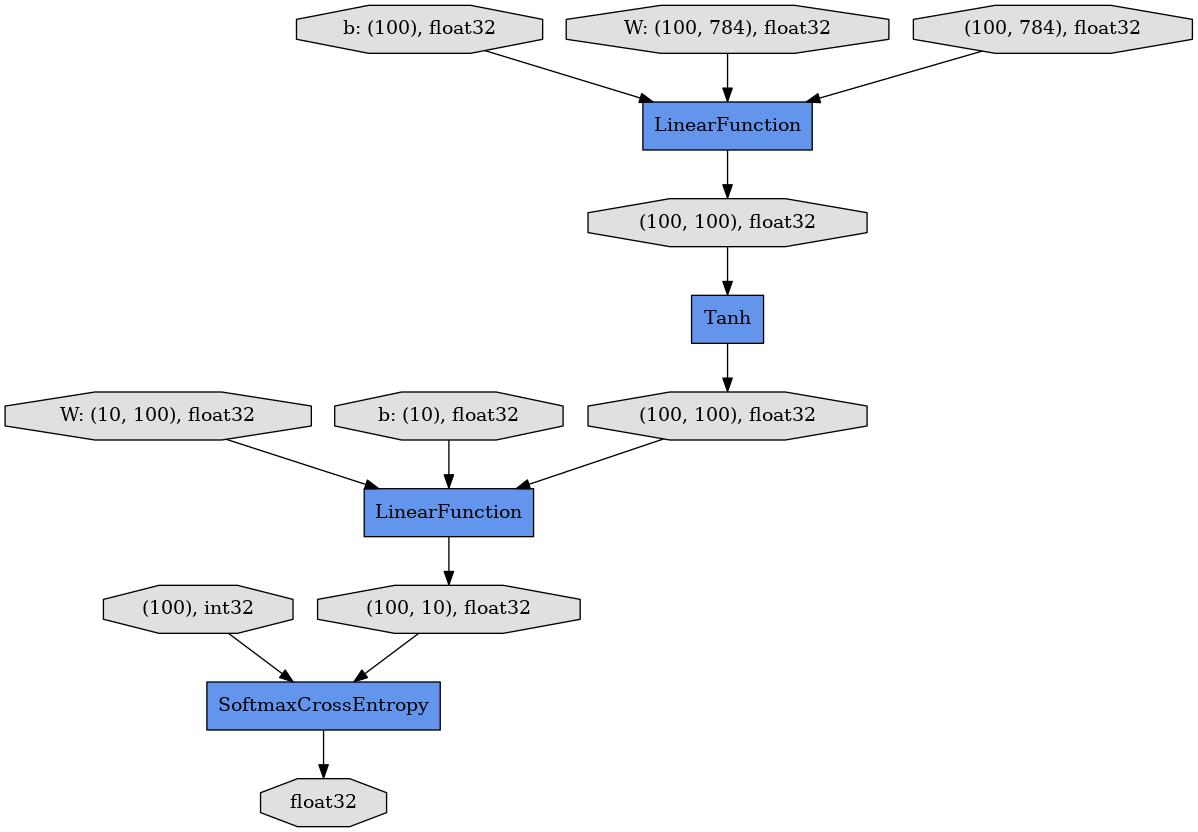

In [11]:
display_graph()

#### 定義: 画像と予測ラベルのプロット

テスト用データセットのMNIST画像60サンプルをプロットする。画像上部の"Answer"がデータセットで与えられた正解であり、"Predict"が現在の分類モデルによる予測結果である。

In [0]:
def plot_examples():
    %matplotlib inline
    plt.figure(figsize=(12,50))
    if enable_cupy:
       model.to_cpu()
    for i in range(45, 105): 
        x = Variable(np.asarray([test[i][0]]))  # test data
        t = Variable(np.asarray([test[i][1]]))  # labels
        y = model(x)
        prediction = y.data.argmax(axis=1)
        example = (test[i][0] * 255).astype(np.int32).reshape(28, 28)
        plt.subplot(20, 5, i - 44)
        plt.imshow(example, cmap='gray')
        plt.title("No.{0} / Answer:{1}, Predict:{2}".format(i, t.data[0], prediction[0]))
        plt.axis("off")
    plt.tight_layout()

#### 実行: いくつかのサンプルが誤分類される

多くのサンプルの数字は正しく分類されているが、誤りも見受けられる。例えば、一行目のNo. 46の画像が'3'と予測されているかもしれないが、人間には正解の通り'1'に見える。同様に、いびつな形をした'6'である二行目のNo. 54を'2'と誤分類していないだろうか。

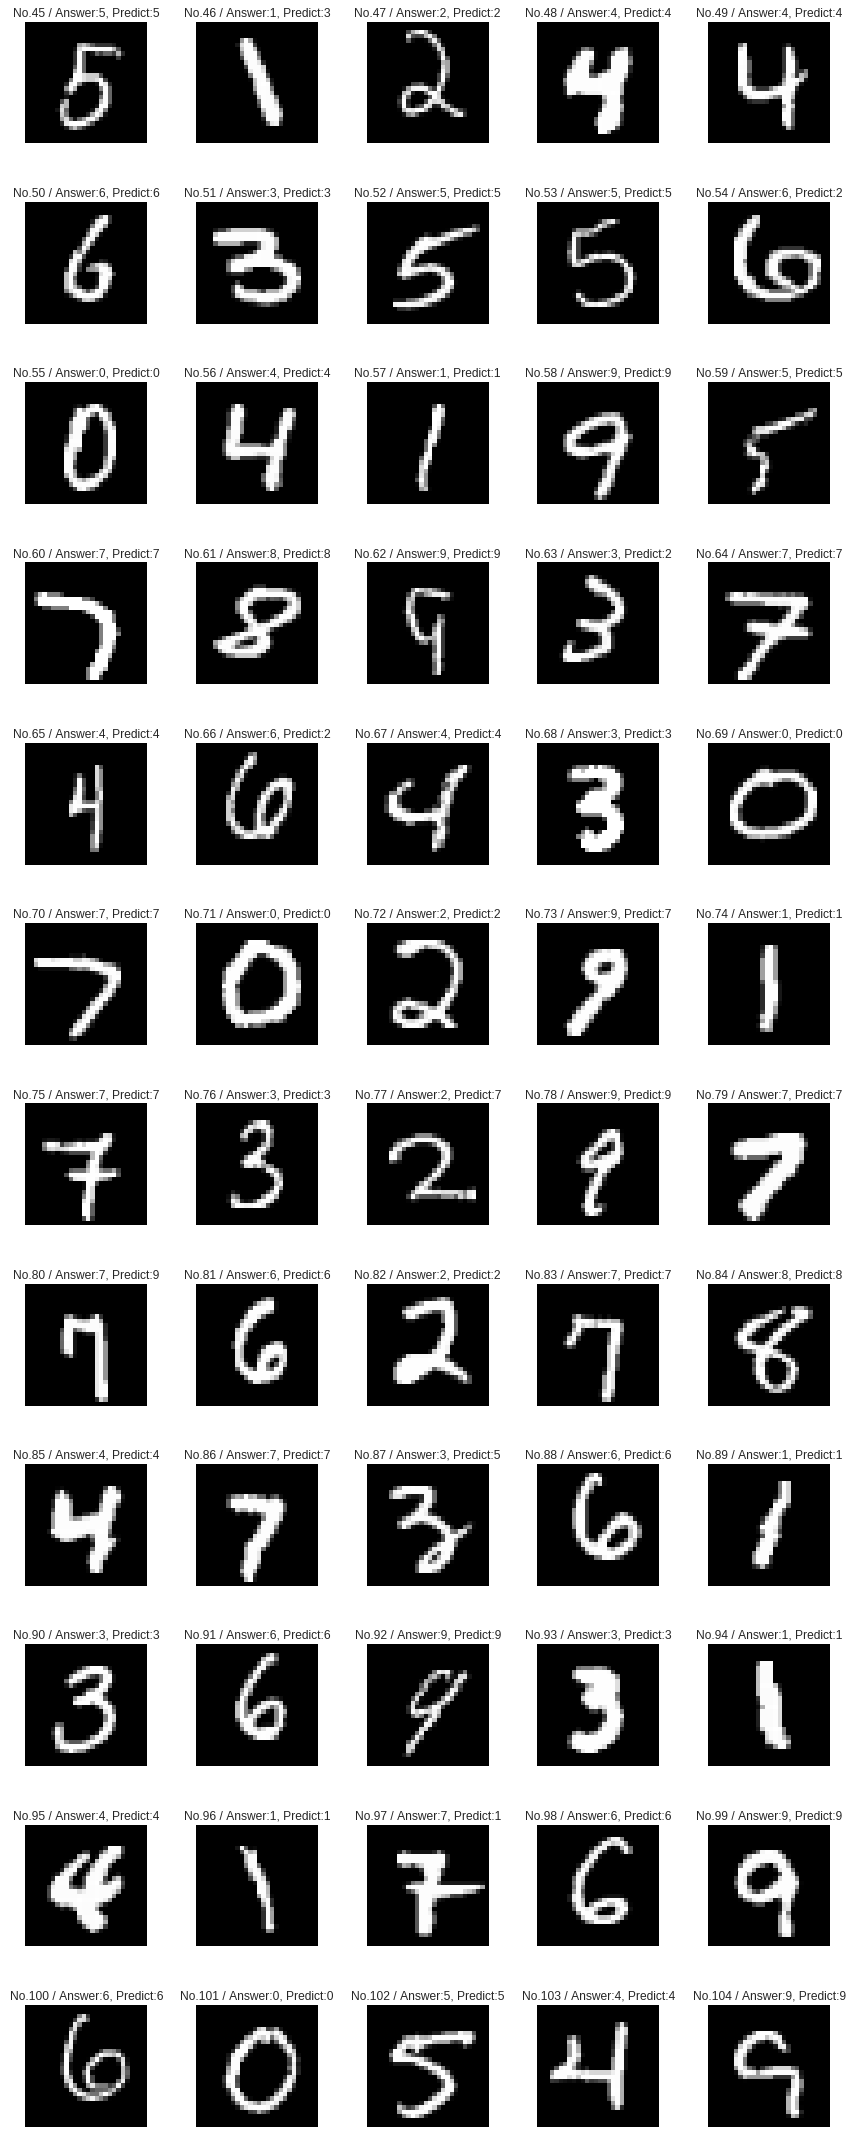

In [13]:
plot_examples()

### Experiment 1.2 - エポック数を増加させてみる

精度向上のために、単にエポック数を増加させることを試みる。他の設定は全て同一のままである。

In [0]:
enable_cupy = False
n_epoch=5                 # Increased from 2 to 5

#### 実行: エポック数5で再実験

エポック数が増えたので実験終了にはより長い時間がかかる。

In [15]:
model = MLP2()
classifier_model = L.Classifier(model)
train_and_test()

epoch       iteration   main/loss   validation/main/loss  main/accuracy  validation/main/accuracy
1           600         1.12974     0.651618              0.758867       0.8604                    
2           1200        0.564204    0.471518              0.865533       0.8859                    
3           1800        0.453113    0.404142              0.883083       0.8959                    
4           2400        0.402744    0.368589              0.892033       0.9013                    
5           3000        0.372716    0.345529              0.897767       0.9063                    
Elapsed time: 33.290


#### 評価: テスト精度が向上していることを確認

前回と比べ損失の値が低減され精度が向上（90%以上）となっていることがわかる。

#### 実行: 誤分類が減ったか確認

先ほど誤分類されたNo.46もしくはNo.54が今回正しく分類されているか確認してみよう。

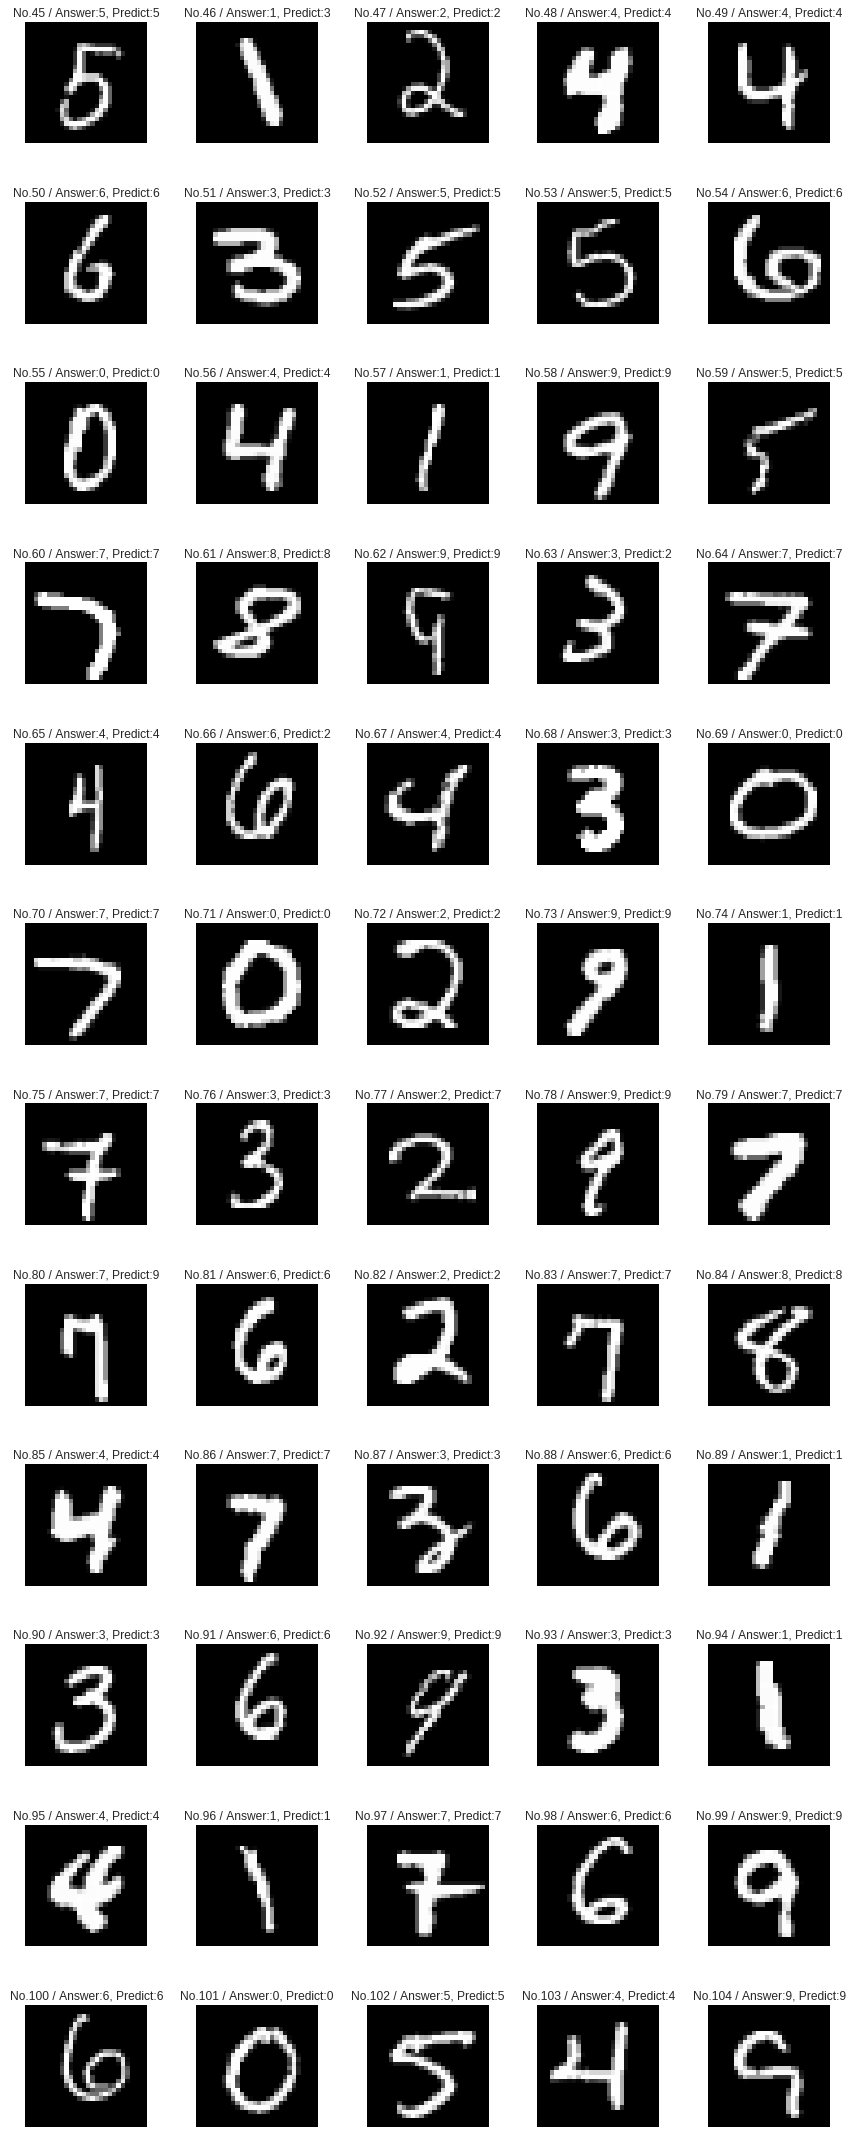

In [16]:
plot_examples()

### Experiment 1.3 - CuPyでGPUを計算に使う

エポック数を増やすことで精度は向上したが、エポック数5ですでに30秒程度かかっている。次のケースでは、CuPyを有効にしてGPUを使うことでこの訓練を高速化する。

In [0]:
enable_cupy = True # Now use CuPy
n_epoch=5

#### 実行: 同じモデルをGPUで訓練

（GPU計算の立ち上がりに時間がかかるが）各エポックの実行速度が明らかに違うことがわかる。

In [18]:
model = MLP2()
classifier_model = L.Classifier(model)
train_and_test()

epoch       iteration   main/loss   validation/main/loss  main/accuracy  validation/main/accuracy
1           600         1.114       0.643112              0.759833       0.8623                    
2           1200        0.559301    0.465749              0.866233       0.8858                    
3           1800        0.450068    0.399867              0.883          0.8964                    
4           2400        0.400445    0.3642                0.891218       0.9014                    
5           3000        0.370953    0.342213              0.897984       0.9054                    
Elapsed time: 49.706


#### 評価: 訓練の高速化結果を確認する

実行時間を比べると、この環境ではGPUによる訓練はCPUに比べて2倍程度である。

### Experiment 1.4 - レイヤーを追加する

今度はレイヤーを増やした異なる多層パーセプトロンを用いる。

#### 定義: 3層の多層パーセプトロン

以下のMLP3は3つの線形レイヤーでつながれた同じ100ノードからなる2つの隠れユニットを持つ。順方向計算でtanhを活性化関数を用いるのも同様である。

In [0]:
## 3-layer multi-Layer Perceptron (MLP)
class MLP3(Chain):
    
    def __init__(self):
        super(MLP3, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(784, 100)
            self.l2=L.Linear(100, 100)   # Additional  layer
            self.l3=L.Linear(100, 10)
        
    def __call__(self, x):
        h1 = F.tanh(self.l1(x))   # Hidden unit 1
        h2 = F.tanh(self.l2(h1)) # Hidden unit 2
        y = self.l3(h2)
        return y

#### 準備: 分類モデルのベースをMLP3とする

In [0]:
enable_cupy = True
n_epoch=5

#### Execution: 新しいMLP3ベースのモデルを訓練する

In [21]:
model = MLP3()  # Use MLP3 instead of MLP2
classifier_model = L.Classifier(model)
train_and_test()

epoch       iteration   main/loss   validation/main/loss  main/accuracy  validation/main/accuracy
1           600         1.06402     0.561088              0.763766       0.872                     
2           1200        0.491097    0.410575              0.876967       0.8931                    
3           1800        0.398214    0.356118              0.893167       0.903                     
4           2400        0.355331    0.325703              0.901285       0.9094                    
5           3000        0.328767    0.306094              0.907801       0.9151                    
Elapsed time: 21.000


#### 評価: MLP2とMLP3の精度を比較する

MLP3は高い表現力によって、MLP2よりも低い損失と高い精度を達成している。一方、内部パラメータも増えるため、訓練に要する時間はわずかに増加する。

#### 実行: MLP3ベースの計算グラフを表示

新しい計算グラフは3つのLinearFunctionと2つのTanh活性化関数を含む。

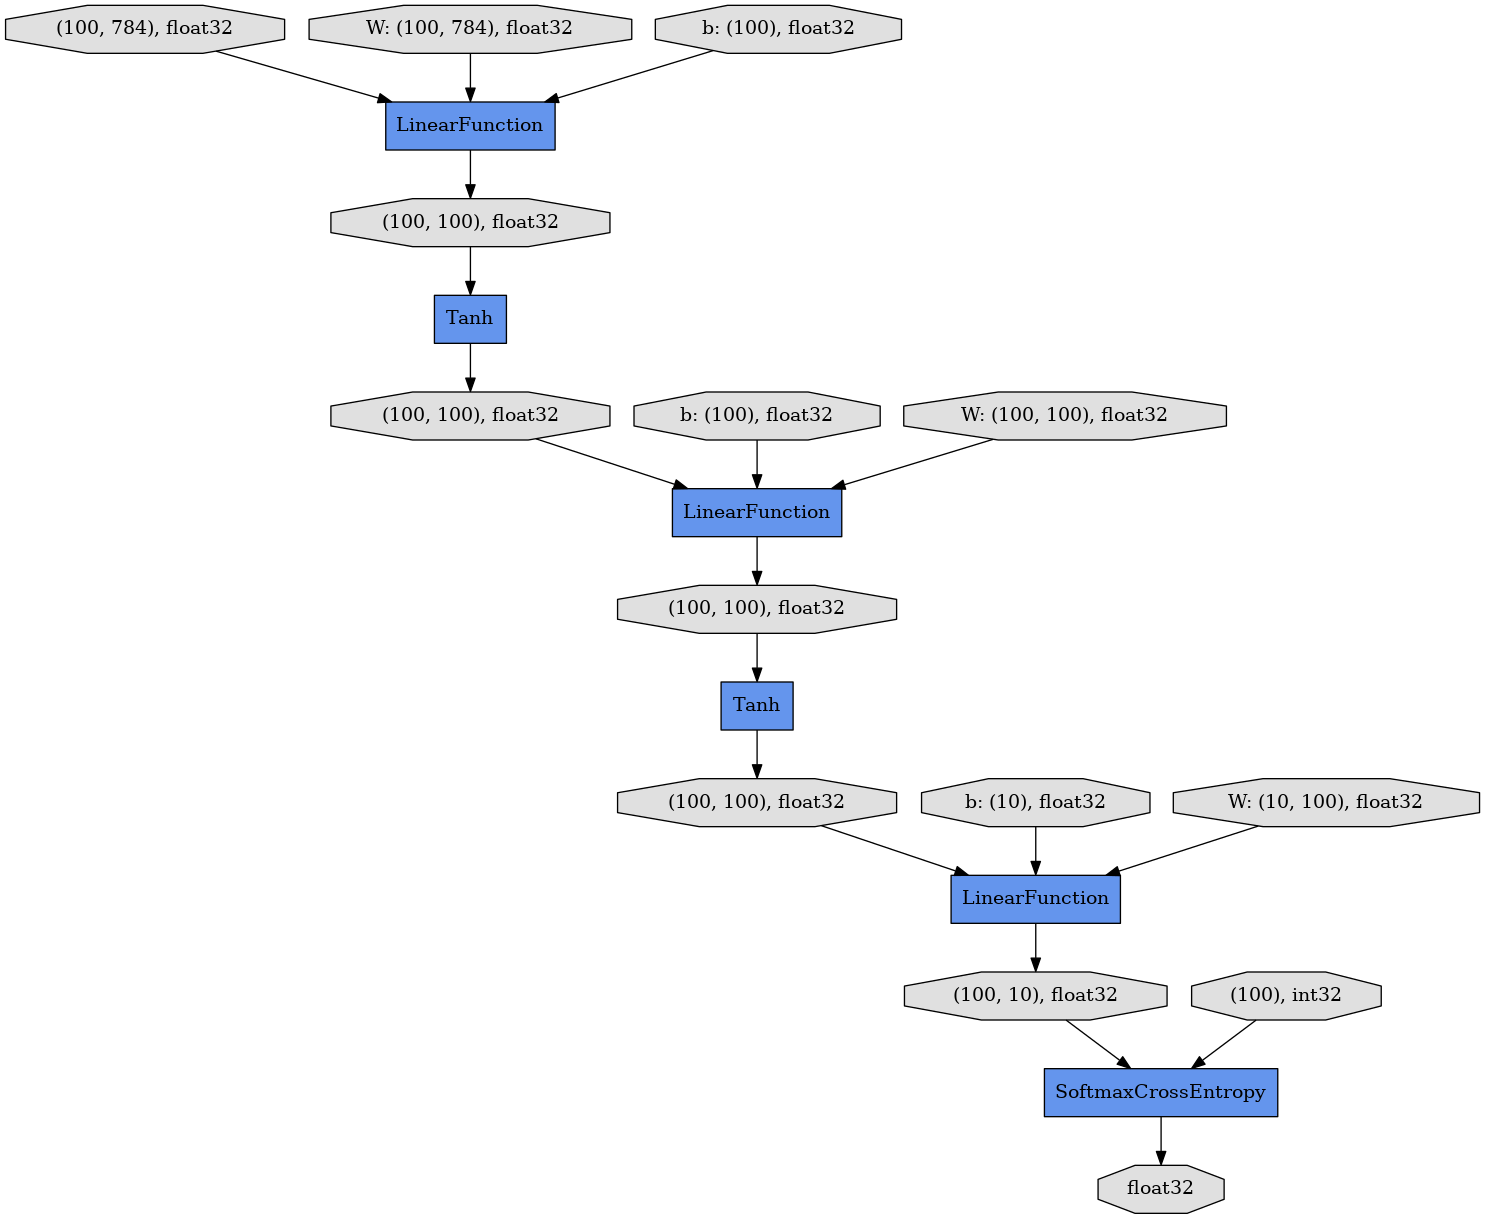

In [22]:
display_graph()

#### 実行: 誤分類サンプルはもうないか？

現在のモデルは先ほどと同様の60サンプルであればほぼ完璧に予測できることが確認できる。

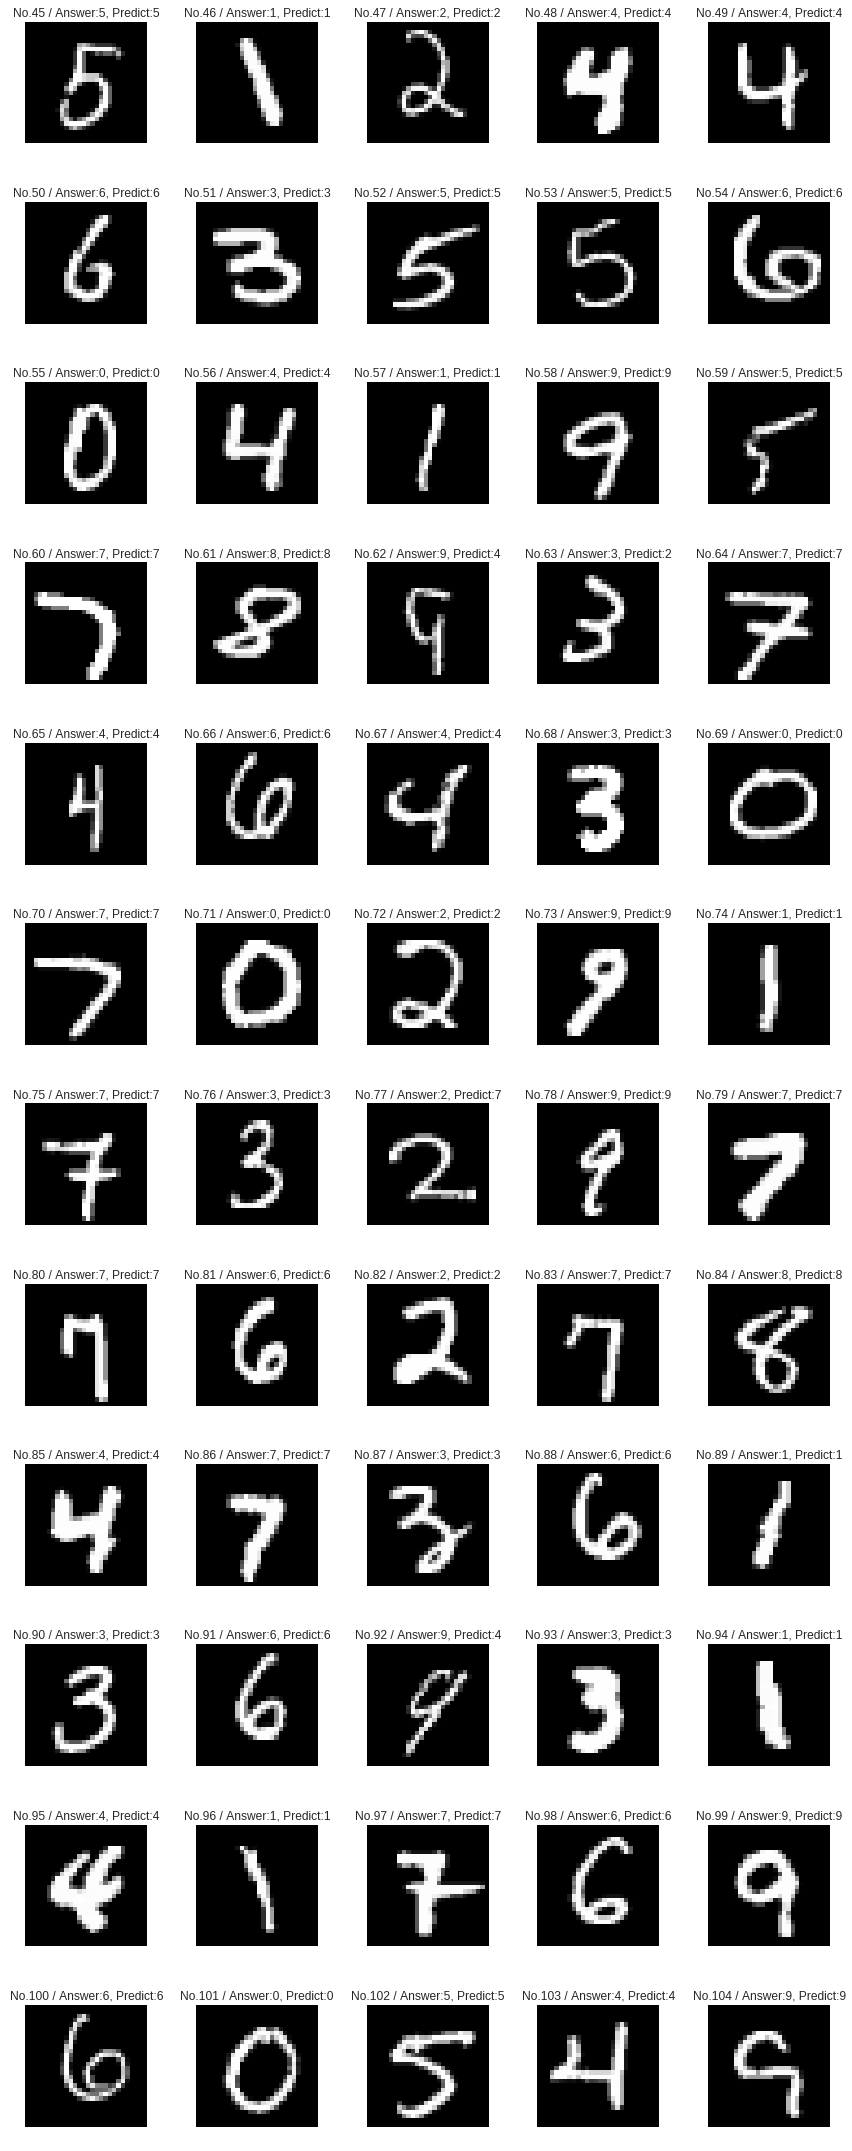

In [23]:
plot_examples()

### Chainerの特長 - (1) デバッグのしやすさ

複雑なニューラルネットワークのデバッグは面倒である、何故なら一般のフレームワークはモデル定義や実装のどこが間違っているのか、直接的には教えてくれない事が多いからだ。しかしChainerでは普通のプログラムをデバッグするかのように行うことができ、順方向計算中の型チェックもサポートしている。

#### 定義: 予めバグを埋め込んだMLP実装

以下のMLP3Wrongは、MLP3に3つのバグをわざと埋め込んだものである。実行しながら1つ1つ解決していこう。

In [0]:
## Find three bugs in this model definition
class MLP3Wrong(Chain):
    
    def __init__(self):
        super(MLP3Wrong, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(748, 100)
            self.l2=L.Linear(100, 100)
            self.l3=L.Linear(100, 10) 

    def __call__(self, x):
        h1 = F.tanh(self.l1(x))
        h2 = F.tanh(self.l2(x))
        y = self.l3(h3)
        return y
    
enable_cupy = True
n_epoch=5

#### 実行: スタックトレースを見るとエラー箇所が判る

以下を実行するとエラーが発生するが、スタックトレースの表示を下まで追うとそれが順方向計算においてどのソースコードのどの行で発生しているかがわかる。これはChainerのDefine-by-Runが、計算グラフを順方向計算中に直接構築しているため可能なことである（Section 2で説明する）。

3つのバグを修正し終わると、MLP3Wrongは先ほどのMLP3と一致するはずである。

In [25]:
model = MLP3Wrong() # MLP3Wrong
classifier_model = L.Classifier(model)
train_and_test()

Exception in main training loop: 
Invalid operation is performed in: LinearFunction (Forward)

Expect: in_types[0].shape[1] == in_types[1].shape[1]
Actual: 784 != 748
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/chainer/training/trainer.py", line 306, in run
    update()
  File "/usr/local/lib/python3.6/dist-packages/chainer/training/updaters/standard_updater.py", line 149, in update
    self.update_core()
  File "/usr/local/lib/python3.6/dist-packages/chainer/training/updaters/standard_updater.py", line 160, in update_core
    optimizer.update(loss_func, *in_arrays)
  File "/usr/local/lib/python3.6/dist-packages/chainer/optimizer.py", line 650, in update
    loss = lossfun(*args, **kwds)
  File "/usr/local/lib/python3.6/dist-packages/chainer/links/model/classifier.py", line 134, in __call__
    self.y = self.predictor(*args, **kwargs)
  File "<ipython-input-24-498a68fb58f0>", line 11, in __call__
    h1 = F.tanh(self.l1(x))
  File "/usr/local/lib/p

InvalidType: ignored

### Experiment 1.5 - 自分のモデルを作ってみよう

それではあなたの番だ。モデルを自分で変更してさらに高い精度を目指してみよう。

エポック数を増やして時間をかけるのは単純過ぎる解決策なので、エポック数10以下、かつ訓練時間100秒以内という制限の中で95％を超える精度を達成してみてほしい。

#### 定義: オプションを駆使して新しいモデルを作る

ニューラルネットワークモデルをチューニングしてパフォーマンスを向上させよう。以下の様なオプションがある。

* エポック数を増やす
* 各ユニットのノード数を増やす
* レイヤー数を増やす
* 異なる活性化関数を用いる

In [0]:
## Let's create new Multi-Layer Perceptron (MLP)
class MLPNew(Chain):
    
    def __init__(self):
        # Add more layers?
        super(MLPNew, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(784, 100)  # Increase output node as (784, 200)?
            self.l2=L.Linear(100, 100)  # Increase nodes as (200, 200)?
            self.l3=L.Linear(100, 10)      # Increase nodes as (200, 10)?

    def __call__(self, x):
        h1 = F.relu(self.l1(x))        # Replace F.tanh with F.sigmoid  or F.relu ?
        h2 = F.relu(self.l2(h1))        # Replace F.tanh with F.sigmoid  or F.relu ?
        y = self.l3(h2)
        return y

enable_cupy = True #  Use CuPy for faster training
n_epoch = 5 # Add more epochs?

#### 実行: 95%以上の精度をもつモデルができただろうか

In [27]:
model = MLPNew()
classifier_model = L.Classifier(model)
train_and_test()

epoch       iteration   main/loss   validation/main/loss  main/accuracy  validation/main/accuracy
1           600         1.37944     0.645228              0.642416       0.8442                    
2           1200        0.513565    0.40484               0.866883       0.8938                    
3           1800        0.386115    0.339986              0.893067       0.9085                    
4           2400        0.338946    0.314279              0.904051       0.9118                    
5           3000        0.311101    0.288255              0.911118       0.9214                    
Elapsed time: 21.501


#### 実行: もう失敗しない？

95%以上の精度があれば、おそらく誤判別は見当たらないはずである。

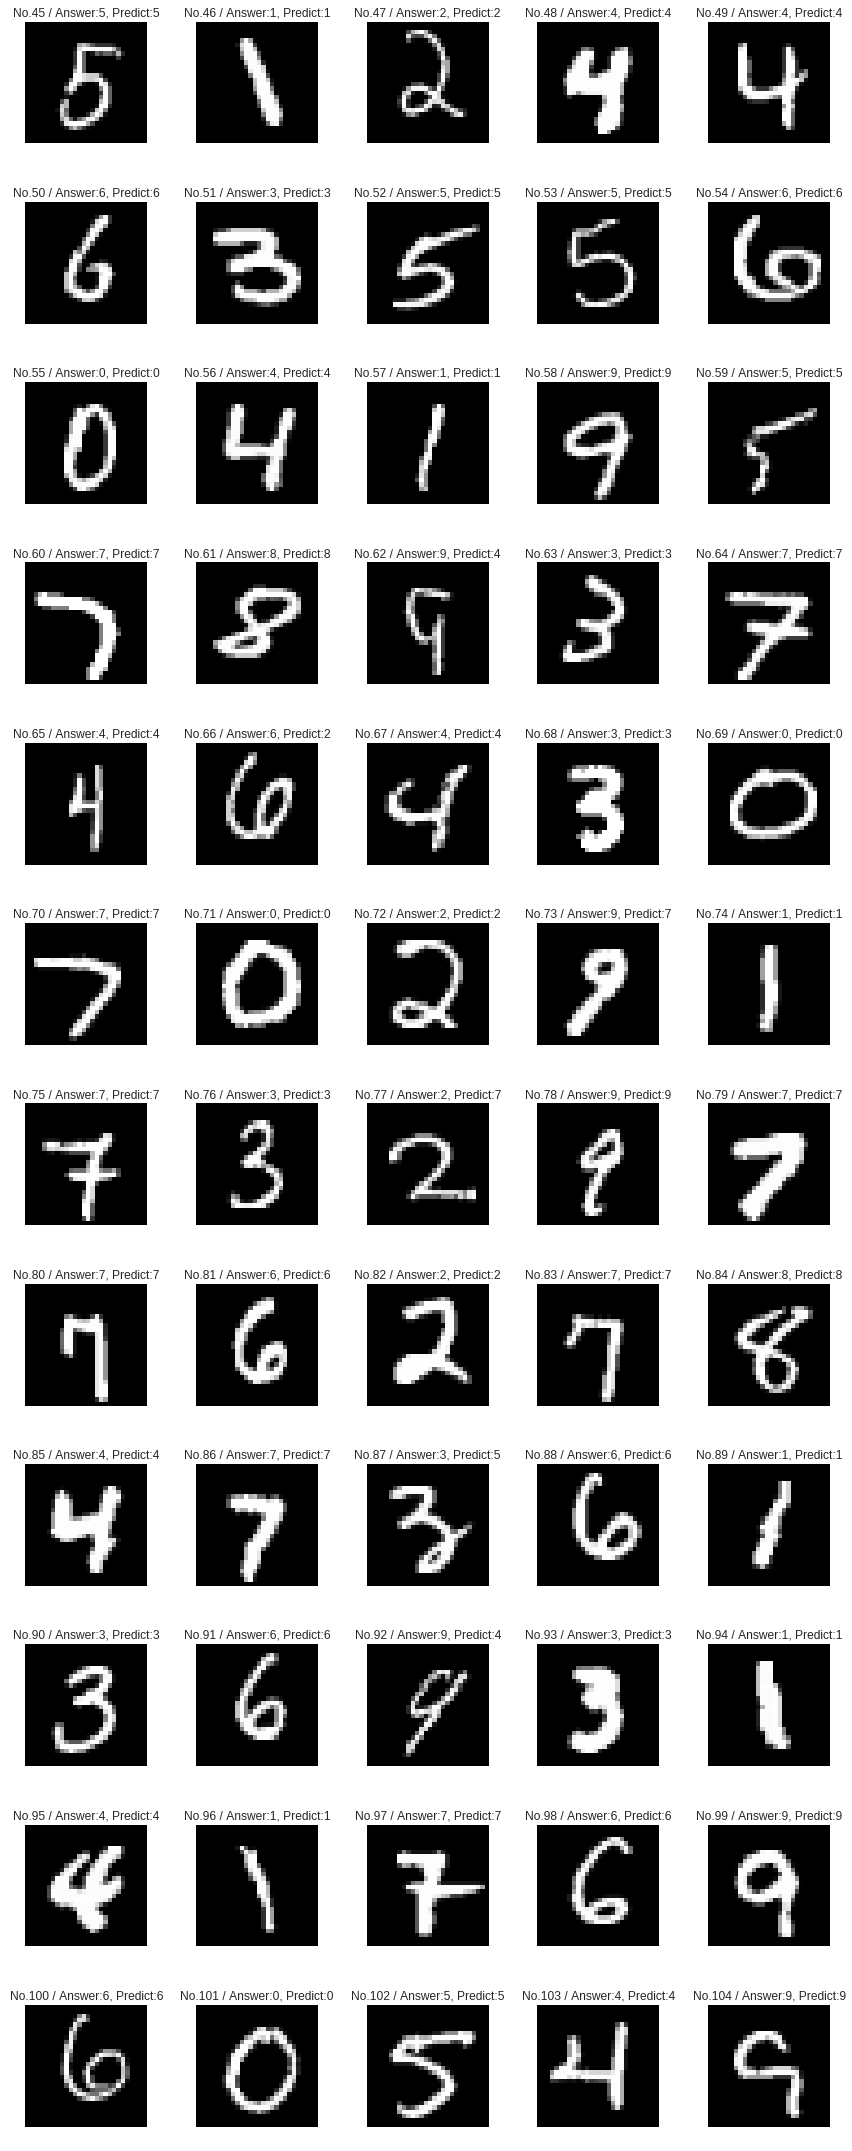

In [28]:
plot_examples()

#### 実行: 自分の作ったベストなモデルの内部を見てみよう

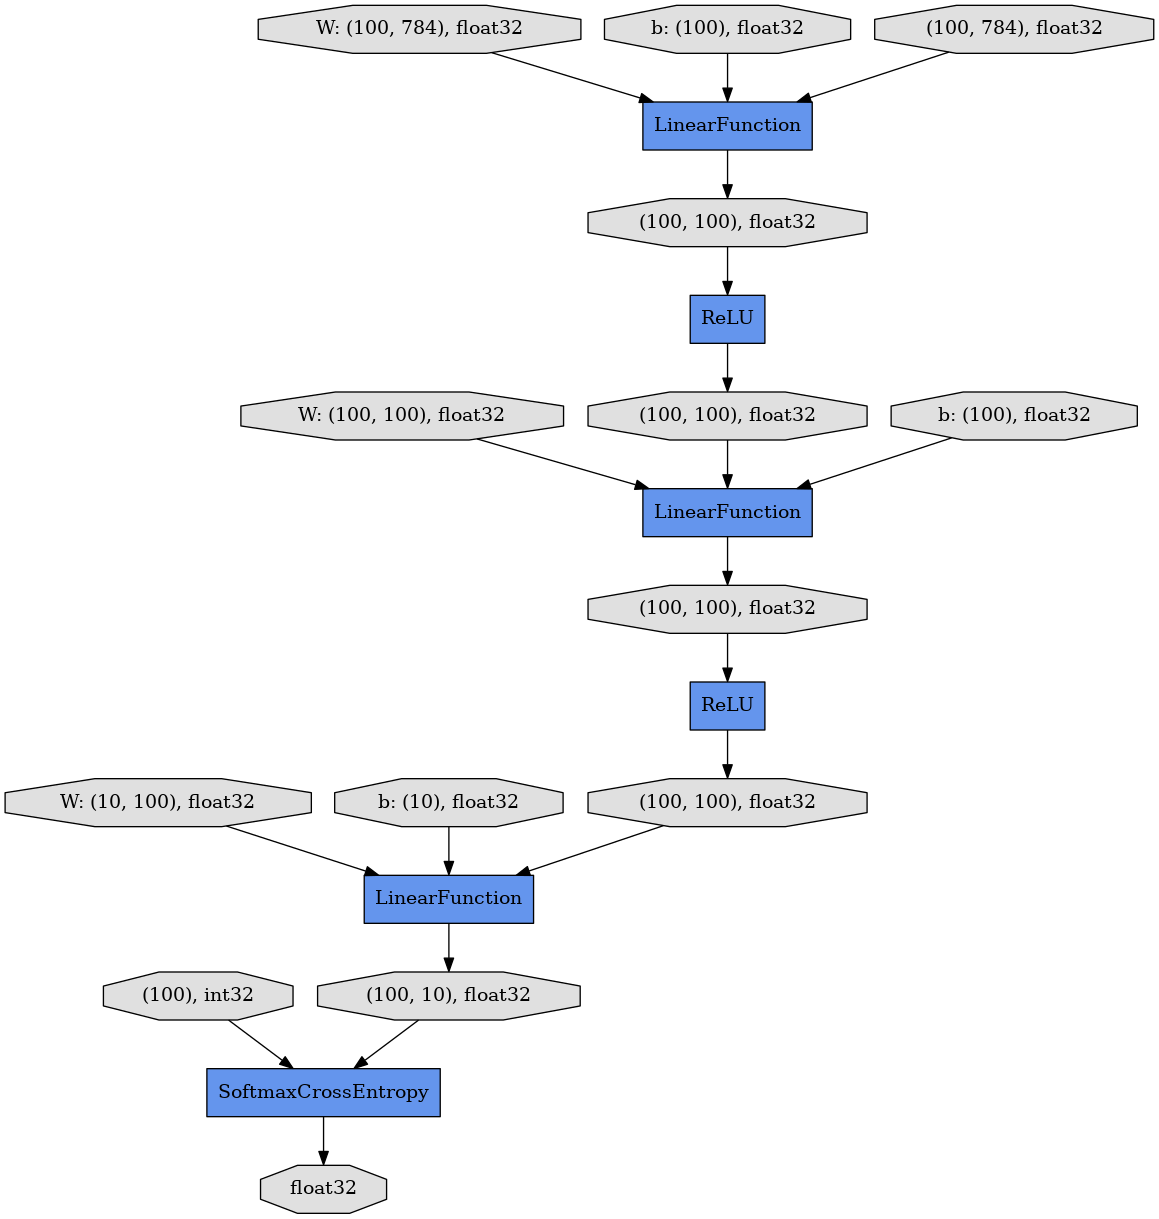

In [29]:
display_graph()

### 発展: 畳み込みニューラルネットワークの実装

このセクションでは、線形（全結合）層を持つ多層パーセプトロンのみを用いた。しかしながら、最近の画像認識におけるディープラーニングの進化は、畳み込みニューラルネットワーク（Convolutional Neural Network; CNN）という異なるタイプがもたらしている。

このハンズオンの内容を超えるためその詳細はここでは割愛するが、ChainerはImageNet画像分類タスクの[example](https://github.com/pfnet/chainer/tree/master/examples/imagenet)に、様々な畳み込みニューラルネットワークの実装を含んでいる。

#### 定義: AlexNetモデル (ImageNetコンテスト2012優勝)

AlexNetは最も標準的なCNNで、ImageNet2012コンテストで優勝したモデルである。

基本的な関数やレイヤーは全てChainerでサポートされているため、ユーザーがこのような標準的なCNNを再実装したり、自分の問題のために拡張できる。例えばAlexNetは以下の様なモジュールを含んでいる。

* Convolutional layer (L.Convolution2D)
* Max pooling (F.max_pooling_2d)
* Local response normalization (F.local_response_normalization)
* Dropout (F.dropout)

関数等の詳細については、Chainerリファレンスマニュアルの[Standard Function implementations](http://docs.chainer.org/en/stable/reference/functions.html)に説明がある。

In [0]:
## Definition of AlexNet
class AlexNet(chainer.Chain):

    def __init__(self):
        super(AlexNet, self).__init__()
        with self.init_scope():
            conv1=L.Convolution2D(3,  96, 11, stride=4)
            conv2=L.Convolution2D(96, 256,  5, pad=2)
            conv3=L.Convolution2D(256, 384,  3, pad=1)
            conv4=L.Convolution2D(384, 384,  3, pad=1)
            conv5=L.Convolution2D(384, 256,  3, pad=1)
            fc6=L.Linear(9216, 4096)
            fc7=L.Linear(4096, 4096)
            fc8=L.Linear(4096, 1000)

        self.train = True
        
    def __call__(self, x, t):
        h = F.max_pooling_2d(F.relu(
            F.local_response_normalization(self.conv1(x))), 3, stride=2)
        h = F.max_pooling_2d(F.relu(
            F.local_response_normalization(self.conv2(h))), 3, stride=2)
        h = F.relu(self.conv3(h))
        h = F.relu(self.conv4(h))
        h = F.max_pooling_2d(F.relu(self.conv5(h)), 3, stride=2)
        h = F.dropout(F.relu(self.fc6(h)), train=self.train)
        h = F.dropout(F.relu(self.fc7(h)), train=self.train)
        y = self.fc8(h)
        return y

----------------------

## Section 2. Chainerの基礎

Section 1では、画像認識をタスク例に、Chainerにおいてどのようにしてニューラルネットワークを定義し訓練するかを説明した。

ユーザーはこのようなパターン認識タスクだけでなく、自分の課題にもChainerを利用できる。しかし、上記の課題ではプリセットに存在するレイヤーや関数を組み合わせるだけでニューラルネットワークを構築していたが、今後はユーザーがゼロからより低レベルのコーディングを行うことで新しいネットワークを作り出す必要があるかもしれない。

Chainerはそのようなユーザーが新しいモデルを迅速にプロトタイピングし、テストし、トライアンドエラーを通じて改良しやすいようにデザインされている。以下では、Chainerのコアとなっているコンポーネントについて説明する。

### 3.1 NumPyとCuPy

NumPyはPythonの数値計算用に広く用いられているライブラリであり、Chainerの中でも用いられている。一方、ニューラルネットワークはGPGPUの多次元配列演算の高速化を必要としている。しかしNumPyはGPUをサポートしていないため、Chainerの初期バージョンではGPUを用いるためにはGPUに特化したコードを常に必要としていた。

そこでChainer開発陣は、NumPy互換性のあるCUDAライブラリとしてCuPyを開発し、Chainerに加えた。CuPyは現在NumPyの多くのAPIをサポートしていおり、ユーザーはほとんどの場合CPU/GPU非依存なコードを書くことができる。

#### 実行: NumPyを試す

NumPyを用いて、行列の生成と処理を行って処理時間を計測する。具体的には、1000x1000の大きさの行列を作り、転置し、各要素を2倍にする操作を5000回繰り返す。

In [31]:
## import numpy as np
a = np.arange(1000000).reshape(1000, -1)
t1 = time.clock()
for i in range(5000):
    a = np.arange(1000000).reshape(1000, -1)
    b = a.T * 2
t2 = time.clock()
print(t2 -t1)

16.400983999999994


#### 実行: CuPyを試す

同じ処理をCuPyで試す。1行目の実行はCUDA関連の初期化に時間がかかるが、5000回のループ処理全体はNumPyと比べて10倍かそれ以上高速になる。

In [32]:
## import cupy as cp
a = cp.arange(1000000).reshape(1000, -1)
t1 = time.clock()
for i in range(5000):
    a = cp.arange(1000000).reshape(1000, -1)
    b = a.T * 2
t2 = time.clock()
print(t2 -t1)

1.8124880000000019


### Chainerの特長 - (2) CPU/GPU互換の行列演算

CuPyは可能な限りNumPyと同じインタフェースを提供しているため、ユーザーは計算ロジックを変更すること無く両者を以下のように切り替えられる。

In [33]:
def xp_test(xp):
    a = xp.arange(1000000).reshape(1000, -1)
    t1 = time.clock()
    for i in range(5000):
        a = xp.arange(1000000).reshape(1000, -1)
        b = a.T * 2
    t2 = time.clock()
    print(t2 -t1)

enable_cupy = False
xp_test(np if not enable_cupy else cp)
enable_cupy = True
xp_test(np if not enable_cupy else cp) 

18.556197999999995
1.3077269999999999


### 3.2 VariableとFunction

VariableとFunctionはそれぞれChainerで基礎的なクラスである。その名前から分かる通り、Variableは変数の値を表し、FunctionはVariableに対する操作を行う（静的な）関数である。

#### 実行: Variableは多次元配列を含むクラス

VariableはNumPyかCuPyの多次元配列インスタンスと共に初期化され、その値は.dataに格納される。

In [34]:
x = Variable(np.asarray([[0, 2],[1, -3]]).astype(np.float32))

print(type(x))
print(type(x.data))
print(x.data)

<class 'chainer.variable.Variable'>
<class 'numpy.ndarray'>
[[ 0.  2.]
 [ 1. -3.]]


#### 実行: VariableはCPUとGPUの間を移動できる

to_gpu()やto_cpu()を呼ぶことで、.dataを含むVariable内の要素はCPU側のNumPyの多次元配列、GPU側のCuPyの多次元配列を行き来できる。

In [35]:
x.to_gpu()
print(type(x.data))
x.to_cpu()
print(type(x.data))

<class 'cupy.core.core.ndarray'>
<class 'numpy.ndarray'>


#### 実行: FunctionはVariableの変換を行う

実際の計算はforward（）メソッド中に記述され、出力もまたVariableのインスタンスになる。

In [36]:
from chainer import function

class MyFunc(function.Function):
    def forward(self, x):
        self.y = x[0] **2 + 2 * x[0] + 1 # y = x^2 + 2x + 1
        return self.y,

def my_func(x):
    return MyFunc()(x)

x = Variable(np.asarray([[0, 2],[1, -3]]).astype(np.float32))
y = my_func(x)
print(type(x))
print(x.data)
print(type(y))
print(y.data)

<class 'chainer.variable.Variable'>
[[ 0.  2.]
 [ 1. -3.]]
<class 'chainer.variable.Variable'>
[[1. 9.]
 [4. 4.]]


#### 実行: Variableは履歴を記憶する

各Variableのインスタンスは自分を生成したFunctionを.creator以下に記憶している。それがNoneの場合、そのVariableインスタンスはrootと呼ばれる。

In [37]:
x = Variable(np.asarray([[0, 2],[1, -3]]).astype(np.float32))

## y is created by MyFunc
y = my_func(x)
print(y.creator)

## z is created by F.sigmoid
z = F.sigmoid(x)
print(z.creator)

## x is created by user
print(x.creator)

None


####  説明: Variableは誤差逆伝搬をネイティブサポートしている

誤差逆伝搬法（backpropagation）はニューラルネットワークを最適化する標準的な手法である。順方向計算のあと、出力に対して損失関数の値が勾配として与えられると、計算グラフを逆順に辿って、各中間ノードに対する勾配が与えられる。そして、その勾配情報を元に各パラメータの値が更新される。

<img src="https://raw.githubusercontent.com/hido/chainer-handson/master/image/backward.png" width="250">

Chainerでは、自動微分がサポートされ、かつ順方向計算中に全てのVariableインスタンスが記録されているため、勾配（.grad）をセットされた出力Variableにたいしてbackward()メソッドを呼ぶと、計算グラフ上をroot（つまり.creatorがNoneである入力ユニットのノード）まで遡って誤差逆伝搬が動作する。その後、Optimizerがモデル（のパラメータ）を更新する。

#### 定義: 順方向計算としての2次式

前のSectionで示したように、順方向計算は、最終的な出力Variableを生成するための演算の連鎖と見なすことができる。その間、Chainerは全ての中間Variableインスタンスを記録している。

In [0]:
## A mock of forward computation
def forward(x):
    z = 2 * x
    y = x ** 2 - z + 1
    return y, z

#### 実行: 勾配を与えるための逆方向計算

y.gradに勾配をセットしy.backward()を実行することで、勾配情報がxとzにまで伝わる。

In [0]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]], dtype=np.float32))
y, z = forward(x)
y.grad = np.ones((2, 3), dtype=np.float32)
y.backward(retain_grad=True)

In [40]:
## Gradient for x: 2*x - 2
print(x.grad)

[[ 0.  2.  4.]
 [ 6.  8. 10.]]


In [41]:
## Gradient for z: -1
print(z.grad)

[[-1. -1. -1.]
 [-1. -1. -1.]]


### 3.3 LinkとChain

Functionは内部状態を持たない特定の演算のみを表していたため、ニューラルネットワーク中のレイヤーのように、パラメータを表す状態を持つ要素としては直接用いることができない。

Linkは、そのような演算へのラッパーとなり、状態を持つ。Linkが再利用可能なモジュールとして定義されるため、大きなネットワーク（後述するChainのインスタンス）の部品として用いることができる。多くの標準的なレイヤーは[chianer.links](http://docs.chainer.org/en/stable/reference/links.html)中に用意されており、これまで用いてきたL.Linearと同様に、L.XYZというカタチで利用できる。

#### 実行: Linkはパラメータを持つ状態付き関数

Linkクラスの多くのコンストラクタは内部パラメータと大きさを表すようないくつかの引数を持つ。それらのパラメータも、Variableのインスタンスとして表現される。

例えば、L.Linearは2つのパラメータ、係数行列のWとバイアス項のbを持つ。L.Linearのコンストラクタはそれらのサイズを決定する2つの引数を持つ。

In [42]:
f = L.Linear(3, 2)
## Weight matrix for linear transformation (randomly initialized)
print(f.W.data)
## Bias term for linear transformation (initialized with zero)
print(f.b.data)

[[-0.40945035  1.0005482  -0.02247001]
 [ 0.09507062 -0.7451292   0.23615319]]
[0. 0.]


#### 実行: Linkのインスタンスを使う

Linkのインスタンスは関数のように、直接呼び出すことができる。

In [0]:
## Apply linear transformation f()
x = Variable(np.array([[1, 2, 3], [4, 5, 6]], dtype=np.float32))
y = f(x)
print(y.data)

#### 実行: Linkに対して勾配を計算する

Link内のパラメータがVariableのインスタンスのため、逆方向計算はそれらにも勾配を与える。

In [0]:
## Initialize gradients of f
f.zerograds()
## Set gradient of y (= loss)
y.grad = np.ones((2, 2), dtype=np.float32)
## Backward computation
y.backward()
## Gradient for f.W and f.b
print(f.W.grad)
print(f.b.grad)

[[5. 7. 9.]
 [5. 7. 9.]]
[2. 2.]


#### 定義: ChainerはLinkの集合、つまりネットワークを表す

以下のクラスはSection 1で扱ったMLP2そのものであるが、Chainクラスを継承している。ニューラルネットワークを表す基底クラスとして、Chainerはパラメータの管理や、CPU/GPU間のto_cpu()とto_gpu()、モデルのシリアライズとファイルへの保存／読み込みなどをサポートしている。

In [0]:
## 2-layer Multi-Layer Perceptron (MLP)
class MLP2(Chain):
    
    # Initialization of layers (Link)
    def __init__(self):
        super(MLP2, self).__init__(
            l1=L.Linear(784, 100),
            l2=L.Linear(100, 10),
        )

    # Forward computation by __call__
    def __call__(self, x):
        h1 = F.tanh(self.l1(x))
        y = self.l2(h1)
        return y

### 発展: Define-by-Runというアプローチ

既存ディープラーニングフレームワークのほとんどでは、モデルの構築と訓練は2つの分離したプロセスとして扱われる。具体的には訓練の前に、モデルの定義（モデル記述テキストやシンボリックなプログラム記述）に従って計算グラフを構築して固定している。この場合のモデル定義は、ディープラーニング用のドメイン特化言語（Domain Specific Language; DSL）の一種と考えられる。その後、訓練データセットを与えられ、実際の訓練プロセスに寄ってモデルを更新する。下の図はその2つのプロセスを表現している。我々はこれをDefine-and-Runと読んでいる。

<img src="https://raw.githubusercontent.com/hido/chainer-handson/master/image/define-and-run.png" width="400">

Define-and-Runは極めて著感的で、かつ訓練の前に計算グラフを最適化しやすいという特徴をもっている。一方、そのデメリットもある。例えば、リカレントニューラルネットワークのようなモデルを記述するときには、特殊な文法を用いる必要がある。また、ネットワークが動的に変化する、例えば部分的に追加・削除される場合でも、可能性のある計算グラフの全てを訓練の最初から最後までメモリ上に保持しておく必要があるため、メモリ効率の面で最適とはいえない場合がある。

それゆえに、ChainerではDefine-by-Runを名付けた異なるアプローチを採用している。ここではモデルの定義が訓練と同時に順方向計算として与えられており、その場で計算グラフが構築される。これによってユーザーはループや条件分岐などを含む複雑なニューラルネットワークを、ホスト言語であるPythonの文法そのままを使って、容易に実装できる。また、Truncated  BPTTのような計算グラフへの変更も、効率的に行われる。

<img src="https://raw.githubusercontent.com/hido/chainer-handson/master/image/define-by-run.png" width="400">

さらなる詳細に興味のあるユーザーは[論文](http://learningsys.org/papers/LearningSys_2015_paper_33.pdf)を参照してほしい。

-----------------------

## Section 3. まとめ

このnotebookではChainerを柔軟で直感的、かつパワフルなディープラーニングフレームワークとして紹介した。特に、最近の学術論文で提案されている複雑なニューラルネットワークモデルを容易に再実装したい時や、新しいアルゴリズムのプロトタイプを実装する際に、Chainerは威力を発揮する。

以下の画像は有名な ["A neural algorithm of Artistic style"](http://arxiv.org/abs/1508.06576)という論文の[Chainer実装](https://github.com/mattya/chainer-gogh)によって生成されたものである。

猫のコンテンツ画像が、横にある様々なスタイル画像と同様の画風となるように再描画されているのがわかる。

<img src="https://raw.githubusercontent.com/hido/chainer-handson/master/image/gogh.png" width="500">

これは単なる一例に過ぎないが、githubのコードを見るとこのような面白いモデルがChainerを使って数百行で再実装できていることがお分かりいただけると思う。
その他にも、ユーザーが様々なユースケースで作成した[コード例のリスト](https://github.com/pfnet/chainer/wiki/External-examples)があるので、参考になれば幸いである。

----------------------------------

これで本notebookは終了である。さらなる詳細は[公式チュートリアル](http://docs.chainer.org/en/stable/tutorial/index.html)を参照されたい。